### Use many events, you ran on one event
1000 events (both training and testing - 2k total events)

Overkill with k-neighbors, so just use the fact that every cell is connected to its neighbors

In [139]:
# Standard libraries
import math
import torch

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.preprocessing import label_binarize

# PyTorch Geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

# PyTorch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm1d

# Jupyter magic for inline plotting
%matplotlib inline

In [140]:
n_bins = 100
center_bin = 50
width = 10
amplitude = 10

In [141]:
def gaussian(amp, mean,sigma):
    return lambda x: amp*math.exp(-(x-mean)**2/(2*sigma**2))

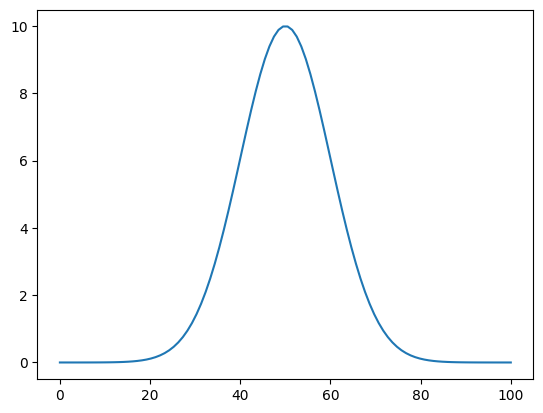

In [142]:
x=np.linspace(0,n_bins,n_bins)
y=list(map(gaussian(amplitude,center_bin,width),x))
plt.plot(x,y)

(array([  3.,  25.,  65., 181., 246., 280., 149.,  34.,  13.,   4.]),
 array([ 68. ,  74.6,  81.2,  87.8,  94.4, 101. , 107.6, 114.2, 120.8,
        127.4, 134. ]),
 <BarContainer object of 10 artists>)

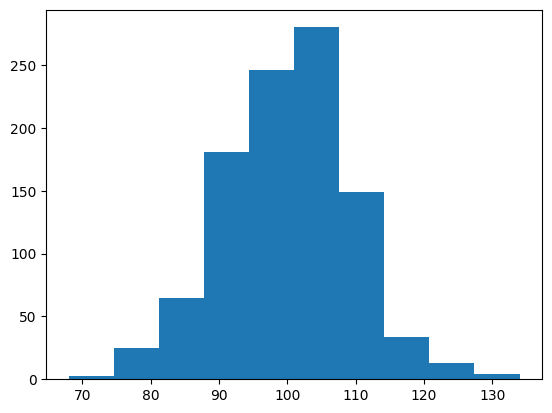

In [143]:
plt.hist(np.random.poisson(lam=100, size=1000))

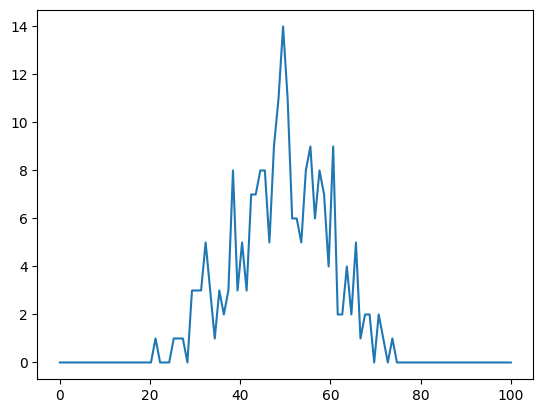

In [144]:
counts = list(map(lambda x: np.random.poisson(lam=x,size=None),y))
plt.plot(x,counts)

<ErrorbarContainer object of 3 artists>

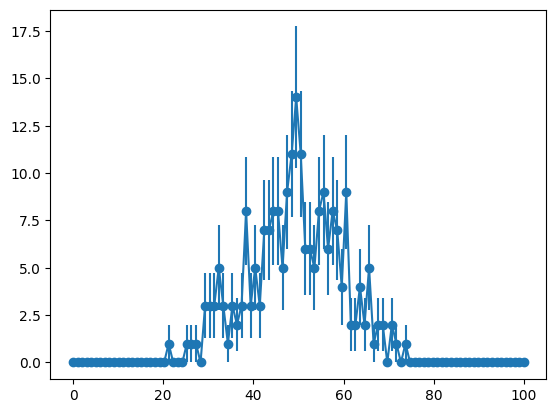

In [145]:
plt.errorbar(x, counts, np.sqrt(counts), marker='o')

In [146]:
def cluster_generator(n_bins = 100, center_bin = 50, width = 10, amplitude = 10 ):
    x=np.linspace(0,n_bins,n_bins)
    y=list(map(gaussian(amplitude,center_bin,width),x))
    counts = list(map(lambda x: np.random.poisson(lam=x,size=None),y))
    return counts

In [147]:
def cluster_event_generator(n_cells, 
                            noise, 
                            n_cluster_generator, 
                            cluster_center_generator,
                            cluster_energy_generator, 
                            cluster_width_generator, 
                            circular=True):
    cells = np.random.normal(0, noise, size= n_cells)
    for _ in range(int(n_cluster_generator())):
        cells += cluster_generator(n_cells, cluster_center_generator(), cluster_width_generator(), cluster_energy_generator())

    return cells            

In [148]:
def normal_gen(mean,sigma):
    return lambda: np.random.normal(mean,sigma,size=None)

In [149]:
n_sigma_truth=2.5

def cluster_event_generator(n_cells, 
                            noise, 
                            n_cluster_generator, 
                            cluster_center_generator,
                            cluster_energy_generator, 
                            cluster_width_generator, 
                            circular=True):
    truth = list()
    n_clusters = max(1, int(n_cluster_generator()))
    clusters = np.zeros((n_clusters,n_cells))

    for i in range(n_clusters):
        truth.append([cluster_center_generator(), cluster_width_generator(), cluster_energy_generator()])
        clusters[i] = cluster_generator(n_cells, *truth[-1])

    cells = np.random.normal(0, noise, size= n_cells)
    cells += np.sum(clusters,axis=0)
    
    truthmap=-1*np.ones((n_clusters,n_cells),dtype="int")
    truth=np.array(truth)
    sorted_index=np.argsort(truth[:,2],axis=0)
    truth=truth[sorted_index]
    clusters=clusters[sorted_index]

    for i,cluster in enumerate(clusters):
        center = truth[i][0]
        width = truth[i][1]
        max_i=min(100,int(center+n_sigma_truth*width))
        min_i=max(0,int(center-n_sigma_truth*width))
        truthmap[i][min_i:max_i]=i

    
    truthmap_projection = np.max(truthmap,axis=0)

    return cells, clusters,truth, truthmap_projection

[[159.61071751   8.25712258 424.98497747]
 [159.21499858  11.4862767  436.00586864]
 [150.23988132   8.96273492 439.45135535]
 [152.44633677  14.07174706 481.8490792 ]
 [135.82056636   7.25387173 489.18869205]
 [144.88174775   6.04442788 505.94734221]
 [154.0867814   14.84821733 509.80076596]
 [139.74007361   8.44676169 512.11640857]
 [138.00409059   8.98894455 515.40709331]
 [155.52395309  10.83870947 553.00901586]]


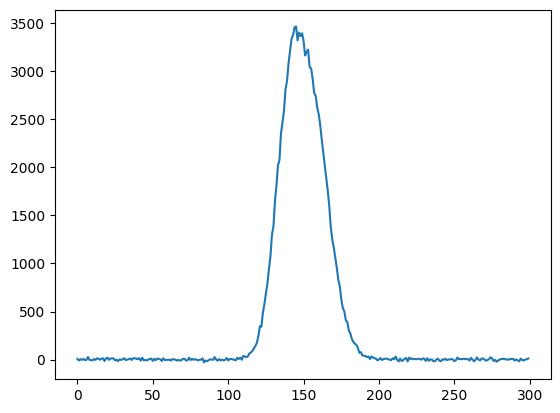

In [150]:
n_cells=300
noise = 10

an_event, clusters, truth, truthmap=cluster_event_generator(n_cells=n_cells,
                        noise = noise,
                        n_cluster_generator=normal_gen(10,3), 
                        cluster_center_generator=normal_gen(150,15),
                        cluster_energy_generator=normal_gen(500,25), 
                        cluster_width_generator=normal_gen(10,2))

plt.plot(an_event)
print(truth)

In [151]:
n_clusters = clusters.shape[0]
truthmap=np.zeros((n_clusters,n_cells),dtype="int")
truth=np.array(truth)
sorted_index=np.argsort(truth[:,2],axis=0)
truth=truth[sorted_index]
clusters=clusters[sorted_index]

cluster_mask = clusters>.0001
for i in range(n_clusters):
    truthmap[i][cluster_mask[i]]=i

truthmap_projection = np.max(truthmap,axis=0)

truthmap_projection

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 6, 0, 0, 8, 6, 8, 6, 3, 8, 8, 8, 8,
       8, 8, 8, 8, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 6, 9, 9, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 0, 0, 3, 6, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [152]:
# truthmap=-1*np.ones((n_clusters,n_cells),dtype="int")
# truth=np.array(truth)
# sorted_index=np.argsort(truth[:,2],axis=0)
# truth=truth[sorted_index]
# clusters=clusters[sorted_index]

# for i,cluster in enumerate(clusters):
#     center = truth[i][0]
#     width = truth[i][1]
#     max_i=min(100,int(center+n_sigma_truth*width))
#     min_i=max(0,int(center-n_sigma_truth*width))
#     truthmap[i][min_i:max_i]=i

    
# truthmap_projection = np.max(truthmap,axis=0)

# truthmap_projection

In [153]:
# Function to assign dynamic edge labels
def get_edge_label(node1, node2):
    if truthmap_projection[node1] == -1 and truthmap_projection[node2] == -1:
        return 0  # Lone-Lone
    elif truthmap_projection[node1] == truthmap_projection[node2]:
        return 1  # True Cluster
    elif truthmap_projection[node1] == -1:
        return 2  # Lone-Cluster
    elif truthmap_projection[node2] == -1:
        return 3  # Cluster-Lone
    else:
        return 4  # Cluster-Cluster

In [154]:
n_events_train = 1000
n_events_test = 1000

n_cluster_generator = normal_gen(10, 3)
cluster_center_generator = normal_gen(150, 15)
cluster_energy_generator = normal_gen(500, 25)
cluster_width_generator = normal_gen(10, 2)


# Function to generate multiple events
def generate_events(n_events):
    event_graphs = []
    
    for _ in range(n_events):
        # Generate event data
        cells, clusters, truth, truthmap_projection = cluster_event_generator(
            n_cells, noise, n_cluster_generator, 
            cluster_center_generator, cluster_energy_generator, 
            cluster_width_generator
        )
        
        # Convert cells into node feature matrix
        x = torch.tensor(cells, dtype=torch.float32).unsqueeze(1)  # (n_cells, 1)

        # Create edges
        num_cells = len(cells)
        edges = [[i, i + 1] for i in range(num_cells - 1)] 
        edge_index = torch.tensor(edges, dtype=torch.long).T  # Shape (2, num_edges)

        # Compute edge labels dynamically
        edge_labels = [get_edge_label(i, j) for i, j in zip(edge_index[0].tolist(), edge_index[1].tolist())]
        y = torch.tensor(edge_labels, dtype=torch.long)

        # Store event as a PyG Data object
        event_graphs.append(Data(x=x, edge_index=edge_index, y=y))
    
    return event_graphs

In [155]:
# Generate training and testing data
train_graphs = generate_events(n_events_train)
test_graphs = generate_events(n_events_test)

# Create PyG data loaders
batch_size = 20
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

KeyboardInterrupt: 

In [ ]:
# cells, clusters, truth, truthmap_projection = cluster_event_generator(
#     n_cells, noise, n_cluster_generator, 
#     cluster_center_generator, cluster_energy_generator, 
#     cluster_width_generator
# )

# # Converting cells into node feature matrix
# x = torch.tensor(cells, dtype=torch.float32).unsqueeze(1)  # (n_cells, 1)

# # Connect each cell to its next one
# num_cells = len(cells)
# edges = [[i, i + 1] for i in range(num_cells - 1)] 

# # Convert to PyG format
# edge_index = torch.tensor(edges, dtype=torch.long).T  # Shape (2, num_edges)

In [ ]:
# # Compute edge labels dynamically
# edge_labels = [get_edge_label(i, j) for i, j in zip(edge_index[0].tolist(), edge_index[1].tolist())]

# # Converting labels to tensors
# y = torch.tensor(edge_labels, dtype=torch.long)

# # Creating graph data object
# graph_data = Data(x=x, edge_index=edge_index, y=y)

In [ ]:
class MultiEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, layer_weights=False, debug=False):
        super(MultiEdgeClassifier, self).__init__()
        self.debug = debug
        self.layer_weights_enabled = layer_weights  # Store setting

        # Node embedding layer
        self.node_embedding = nn.Linear(input_dim, hidden_dim)

        # Initialize convolution and batch norm layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.layer_weights = nn.ParameterList() if layer_weights else None  # Only create if enabled

        # First layer
        self.convs.append(GCNConv(hidden_dim, 128))
        self.bns.append(BatchNorm1d(128))
        if layer_weights:
            self.layer_weights.append(nn.Parameter(torch.tensor(1.0, requires_grad=True)))

        # Additional layers
        for i in range(1, num_layers):
            in_channels = 128 if i == 1 else 64
            out_channels = 64
            self.convs.append(GCNConv(in_channels, out_channels))
            self.bns.append(BatchNorm1d(out_channels))
            if layer_weights:
                self.layer_weights.append(nn.Parameter(torch.tensor(1.0, requires_grad=True)))

        # Edge classification layer
        self.fc = nn.Linear(128, output_dim)

    def debug_print(self, message):
        if self.debug:
            print(message)

    def forward(self, x, edge_index, edge_index_out):
        # Node embedding
        x = self.node_embedding(x)
        self.debug_print(f"Node embedding output shape: {x.shape}")

        if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
            x = x.squeeze(0)

        # Loop through convolution layers
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            self.debug_print(f"After GCNConv {i+1}: {x.shape}")
            if x.dim() == 3 and x.size(0) == 1:
                x = x.squeeze(0)
            x = self.bns[i](x)
            x = torch.relu(x)

            # Apply layer weight if enabled
            if self.layer_weights_enabled:
                x = x * self.layer_weights[i]
                self.debug_print(f"After Layer Weight {i+1}: {x.shape}")

        # Edge representations
        edge_rep = torch.cat([x[edge_index_out[0]], x[edge_index_out[1]]], dim=1)
        self.debug_print(f"Edge representation shape: {edge_rep.shape}")

        # Return Logits
        edge_scores = self.fc(edge_rep)
        return edge_scores


In [ ]:
input_dim = 1  
hidden_dim = 256
output_dim = 5 
num_layers = 3
num_epochs = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiEdgeClassifier(input_dim, hidden_dim, output_dim, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Initialize lists to store data for each epoch
train_loss_per_epoch, train_scores_per_epoch, train_truth_labels_per_epoch = [], [], []
test_loss_per_epoch, test_scores_per_epoch, test_truth_labels_per_epoch = [], [], []

# Training and testing loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set model to training mode
    epoch_train_loss = 0
    epoch_train_scores, epoch_train_truth_labels = [], []

    for graph_data in train_loader:
        optimizer.zero_grad()
        edge_scores = model(graph_data.x, graph_data.edge_index, graph_data.edge_index)  # Shape: (num_edges, 5)
        edge_scores = F.softmax(edge_scores, dim=-1)

        loss = loss_fn(edge_scores, graph_data.y)
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_train_loss += loss.item()
        epoch_train_scores.append(edge_scores.cpu().detach().numpy())
        epoch_train_truth_labels.append(graph_data.y.cpu().numpy())

    epoch_train_scores = np.concatenate(epoch_train_scores, axis=0)
    epoch_train_truth_labels = np.concatenate(epoch_train_truth_labels, axis=0)

    train_scores_per_epoch.append(epoch_train_scores)
    train_truth_labels_per_epoch.append(epoch_train_truth_labels)
    train_loss_per_epoch.append(epoch_train_loss / len(train_loader))

    # Testing Phase
    model.eval()  # Set model to evaluation mode
    epoch_test_loss = 0
    epoch_test_scores, epoch_test_truth_labels = [], []

    for graph_data in test_loader:
        with torch.no_grad():
            edge_scores = model(graph_data.x, graph_data.edge_index, graph_data.edge_index)  # Shape: (num_edges, 5)
            edge_scores = F.softmax(edge_scores, dim=-1)
            loss = loss_fn(edge_scores, graph_data.y)

        epoch_test_loss += loss.item()
        epoch_test_scores.append(edge_scores.cpu().detach().numpy())
        epoch_test_truth_labels.append(graph_data.y.cpu().numpy())

    epoch_test_scores = np.concatenate(epoch_test_scores, axis=0)
    epoch_test_truth_labels = np.concatenate(epoch_test_truth_labels, axis=0)

    test_scores_per_epoch.append(epoch_test_scores)
    test_truth_labels_per_epoch.append(epoch_test_truth_labels)
    test_loss_per_epoch.append(epoch_test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss / len(train_loader):.4f} | Test Loss: {epoch_test_loss / len(test_loader):.4f}")

# Final concatenation of results
train_scores = np.array(train_scores_per_epoch)
train_truth_labels = np.array(train_truth_labels_per_epoch)
test_scores = np.array(test_scores_per_epoch)
test_truth_labels = np.array(test_truth_labels_per_epoch)

# Print shapes
print("Train Loss per Epoch Shape:", np.array(train_loss_per_epoch).shape)
print("Train Scores Shape:", train_scores.shape)
print("Train Truth Labels Shape:", train_truth_labels.shape)
print("Test Loss per Epoch Shape:", np.array(test_loss_per_epoch).shape)
print("Test Scores Shape:", test_scores.shape)
print("Test Truth Labels Shape:", test_truth_labels.shape)


Epoch 1/300 | Train Loss: 1.2864 | Test Loss: 1.0903
Epoch 2/300 | Train Loss: 1.0926 | Test Loss: 1.1115
Epoch 3/300 | Train Loss: 1.0824 | Test Loss: 1.0607
Epoch 4/300 | Train Loss: 1.0800 | Test Loss: 1.0766
Epoch 5/300 | Train Loss: 1.0744 | Test Loss: 1.0744
Epoch 6/300 | Train Loss: 1.0731 | Test Loss: 1.0757
Epoch 7/300 | Train Loss: 1.0730 | Test Loss: 1.0729
Epoch 8/300 | Train Loss: 1.0729 | Test Loss: 1.0728
Epoch 9/300 | Train Loss: 1.0729 | Test Loss: 1.0744
Epoch 10/300 | Train Loss: 1.0729 | Test Loss: 1.0748
Epoch 11/300 | Train Loss: 1.0729 | Test Loss: 1.0744
Epoch 12/300 | Train Loss: 1.0730 | Test Loss: 1.0749
Epoch 13/300 | Train Loss: 1.0730 | Test Loss: 1.0738
Epoch 14/300 | Train Loss: 1.0730 | Test Loss: 1.0740
Epoch 15/300 | Train Loss: 1.0729 | Test Loss: 1.0759
Epoch 16/300 | Train Loss: 1.0730 | Test Loss: 1.0743
Epoch 17/300 | Train Loss: 1.0730 | Test Loss: 1.0734
Epoch 18/300 | Train Loss: 1.0730 | Test Loss: 1.0756
Epoch 19/300 | Train Loss: 1.0729 | T

KeyboardInterrupt: 

In [ ]:
array_of_epochs = np.arange(len(train_loss_per_epoch))

# Class names and colors
class_names = ['Lone-Lone', 'True-True', 'Cluster-Lone', 'Lone-Cluster', 'Cluster-Cluster']
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple']

# Optimal thresholds per class
optimal_thresholds = {
    'Lone-Lone': 0.1,
    'True-True': 0.2,
    'Cluster-Lone': 0.1,
    'Lone-Cluster': 0.1,
    'Cluster-Cluster': 0.1
}
class_thresholds = np.array([optimal_thresholds[label] for label in class_names])

# Convert lists to numpy arrays
train_scores_per_epoch = np.array(train_scores_per_epoch)
test_scores_per_epoch = np.array(test_scores_per_epoch)

# Determine global score range for training and testing data
global_min_train = train_scores_per_epoch.min()
global_max_train = train_scores_per_epoch.max()
global_min_test = test_scores_per_epoch.min()
global_max_test = test_scores_per_epoch.max()

# Define common bin edges
num_bins = 50
common_bins_train = np.linspace(global_min_train, global_max_train, num_bins + 1)
common_bins_test = np.linspace(global_min_test, global_max_test, num_bins + 1)

In [ ]:
# Function to plot loss curves
def plot_loss_curves(loss):
    plt.figure(figsize=(8, 6))
    plt.plot(array_of_epochs, loss, label='Loss per Epoch')
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch for GCNConv and No Class Weights")
    plt.legend()
    plt.show()

# Function to plot ROC curves
# Function to plot ROC curves for the last epoch
def plot_roc_curves(score, labels):
    last_epoch_scores = score[-1]  # Get scores for the last epoch
    last_epoch_labels = labels[-1]  # Get truth labels for the last epoch
    labels_binarized = label_binarize(last_epoch_labels.flatten(), classes=np.arange(len(class_names)))
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(labels_binarized[:, i], last_epoch_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Last Epoch")
    plt.legend(loc="lower right")
    plt.show()

# Function to plot class-wise score distributions
def plot_class_wise_distributions(scores, truth_labels, class_names, optimal_thresholds, common_bins, colors):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    fig.suptitle("Class-wise Score Distributions with Optimal Threshold Overlays", fontsize=16)
    
    # Loop over each class and plot the distributions
    for idx, class_name in enumerate(class_names):
        ax = axes[idx]
        ax.set_title(class_name)
        ax.set_xlabel('Score')
        ax.set_ylabel('Density')
        
        # Get the optimal threshold for the current class
        optimal_thresh = optimal_thresholds[class_name]
        
        # Loop over truth types to filter and plot the scores for each truth type
        for truth_type in sorted(np.unique(truth_labels)):
            class_scores = scores[truth_labels == truth_type, idx]
            fraction_above = np.mean(class_scores > optimal_thresh) if class_scores.size > 0 else 0.0
            ax.hist(class_scores, bins=common_bins, density=True, alpha=0.6, 
                    label=f'Truth {truth_type} (> {fraction_above:.3%})', 
                    color=colors[truth_type % len(colors)])
        
        # Plot the optimal threshold line
        ax.axvline(optimal_thresh, color='black', linestyle='dashed', linewidth=2, 
                   label=f'Threshold: {optimal_thresh:.3f}')
        ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Function to plot truth-type wise score distributions
def plot_truth_type_distributions(scores, truth_labels, class_names, optimal_thresholds, common_bins, colors):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    fig.suptitle("Truth Type-wise Score Distributions for All Output Classes", fontsize=16)
    
    unique_truth_types = sorted(np.unique(truth_labels))
    
    # Loop over each truth type and plot the distributions
    for idx, truth_type in enumerate(unique_truth_types):
        ax = axes[idx]
        ax.set_title(f'Truth Type {truth_type}')
        ax.set_xlabel('Score')
        ax.set_ylabel('Density')
        
        # Get the optimal threshold for the associated class
        associated_class_idx = truth_type
        optimal_threshold = optimal_thresholds[class_names[associated_class_idx]]
        
        # Loop over each class and plot the scores for the current truth type
        for class_idx, class_name in enumerate(class_names):
            class_scores = scores[truth_labels == truth_type, class_idx]
            fraction_above = np.mean(class_scores > optimal_threshold) * 100 if class_scores.size > 0 else 0.0
            ax.hist(class_scores, bins=common_bins, density=True, alpha=0.6, 
                    label=f'Class {class_idx} ({fraction_above:.3f}%)', 
                    color=colors[class_idx % len(colors)])
        
        # Plot the optimal threshold line
        ax.axvline(optimal_threshold, color='black', linestyle='dashed', linewidth=2, 
                   label=f'Threshold: {optimal_threshold:.3f}')
        ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Function to compute and plot confusion matrix
def plot_confusion_matrix(scores, truth_labels, class_names, class_thresholds, epoch_idx):
    # Select the scores and truth labels for the given epoch
    epoch_scores = scores[epoch_idx]  # Shape: (num_edges_in_epoch, 5)
    epoch_truth_labels = truth_labels[epoch_idx]  # Shape: (num_edges_in_epoch,)
    
    y_pred = np.full(epoch_scores.shape[0], -1)
    
    # Get predicted labels based on the thresholds
    for i, label in enumerate(class_names):
        mask = epoch_scores[:, i] >= class_thresholds[i]
        y_pred[mask] = i
    
    # If there are any unassigned labels, assign them to the highest score
    y_pred[y_pred == -1] = np.argmax(epoch_scores[y_pred == -1], axis=1)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(epoch_truth_labels, y_pred, labels=np.arange(len(class_names)))
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix at Epoch {epoch_idx}")
    plt.show()

### Training

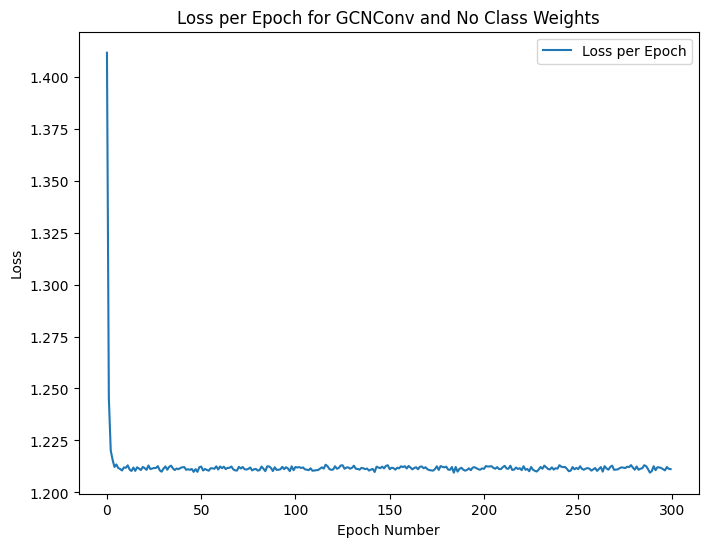

/home/mxg1065/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


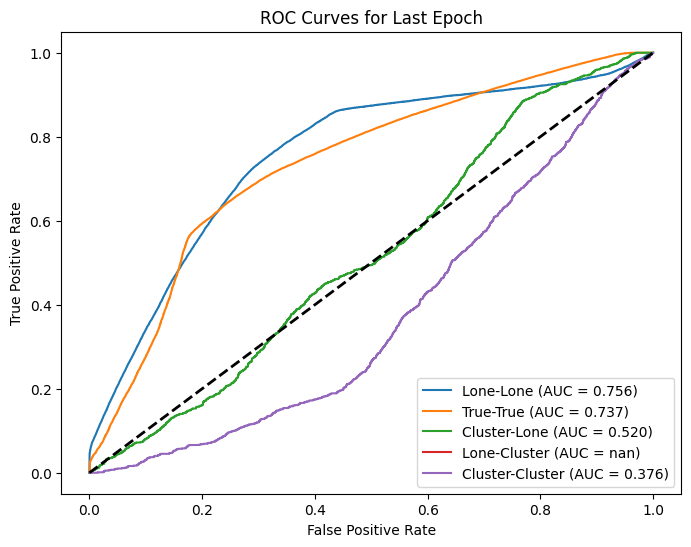

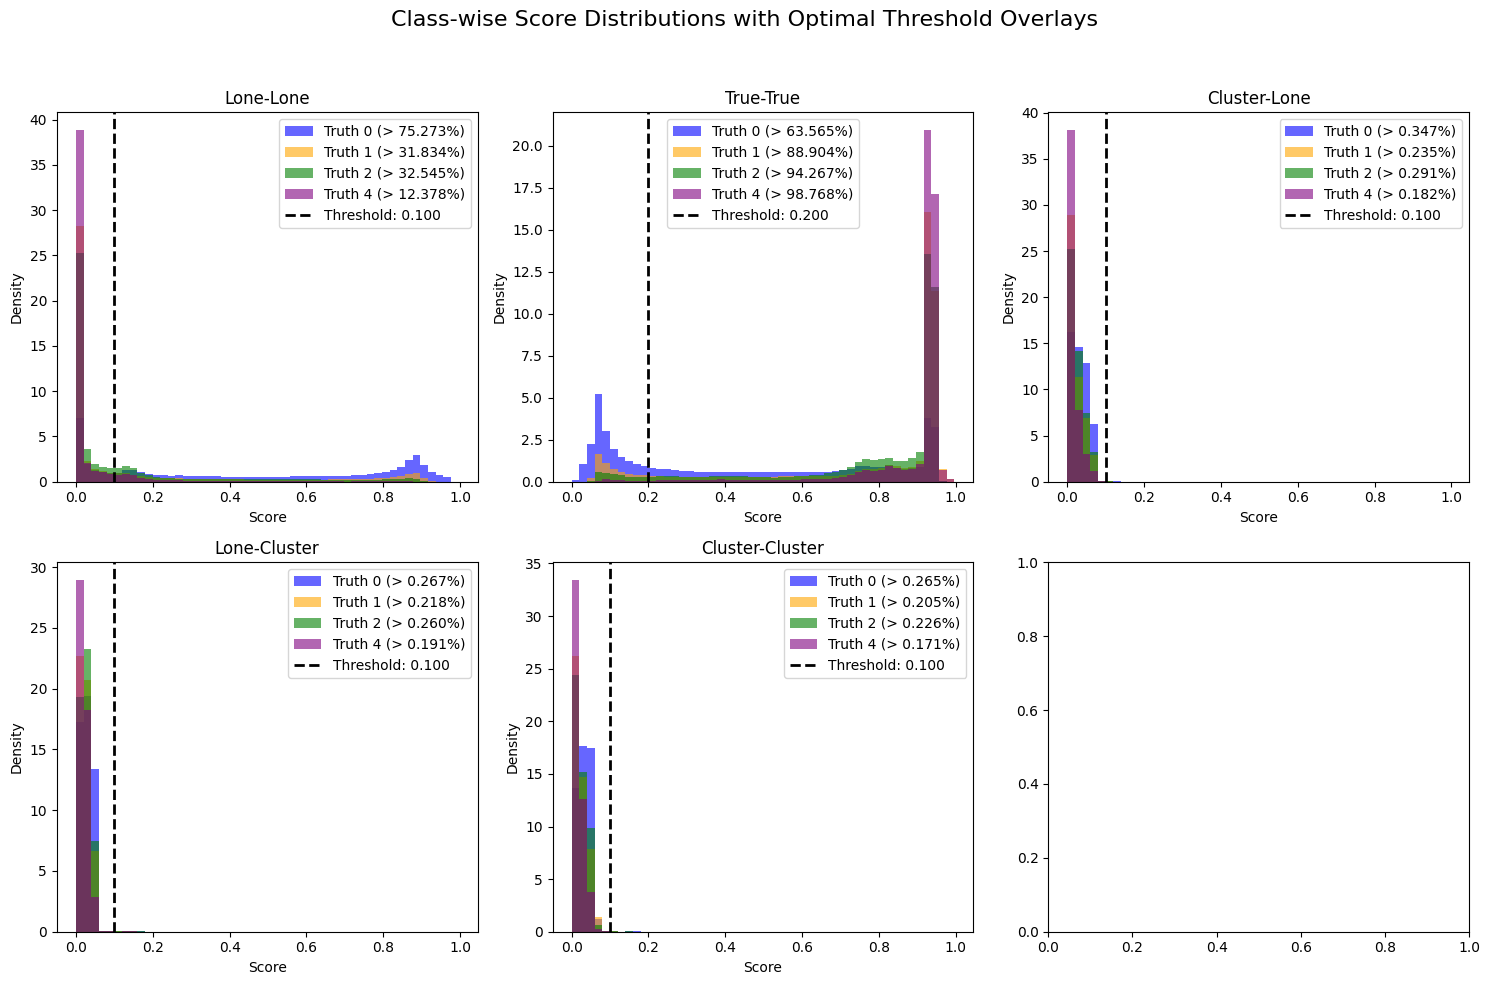

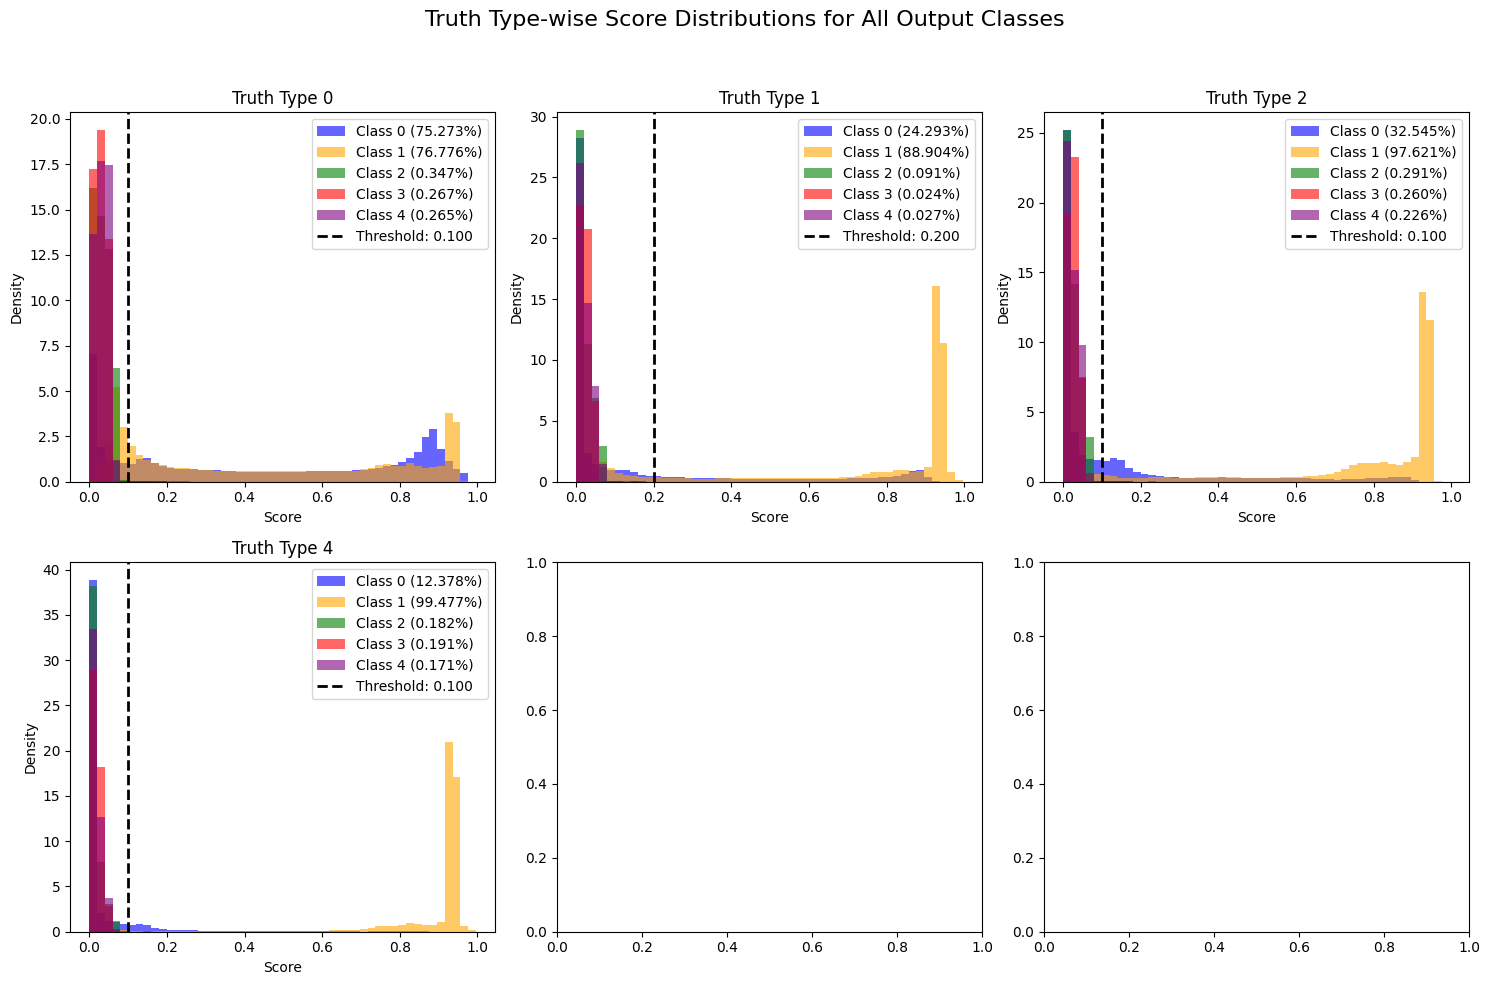

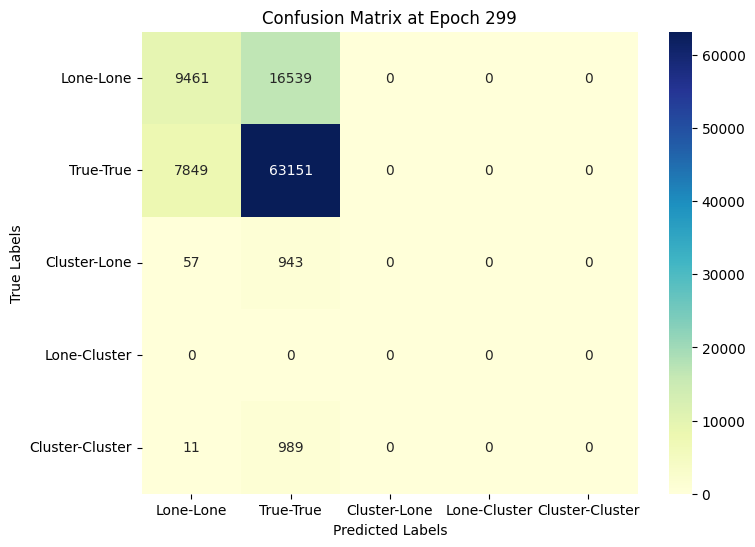

In [ ]:
plot_loss_curves(train_loss_per_epoch)
plot_roc_curves(train_scores_per_epoch, train_truth_labels)
plot_class_wise_distributions(train_scores_per_epoch, 
                              train_truth_labels, 
                              class_names, optimal_thresholds,
                              common_bins_train, 
                              colors)
plot_truth_type_distributions(train_scores_per_epoch, 
                              train_truth_labels, 
                              class_names, 
                              optimal_thresholds, 
                              common_bins_train, 
                              colors)
plot_confusion_matrix(train_scores_per_epoch, train_truth_labels, class_names, class_thresholds, 299)

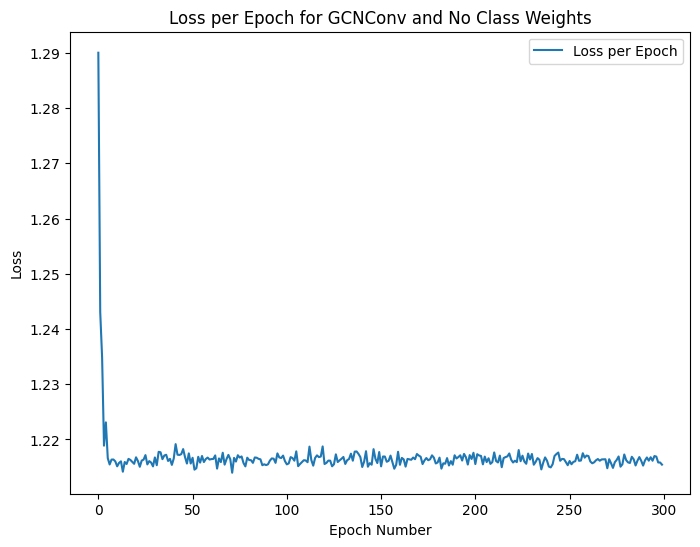

/home/mxg1065/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


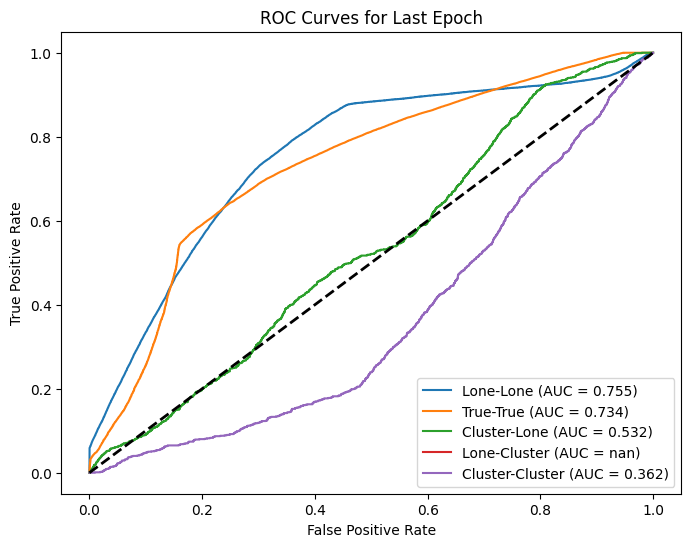

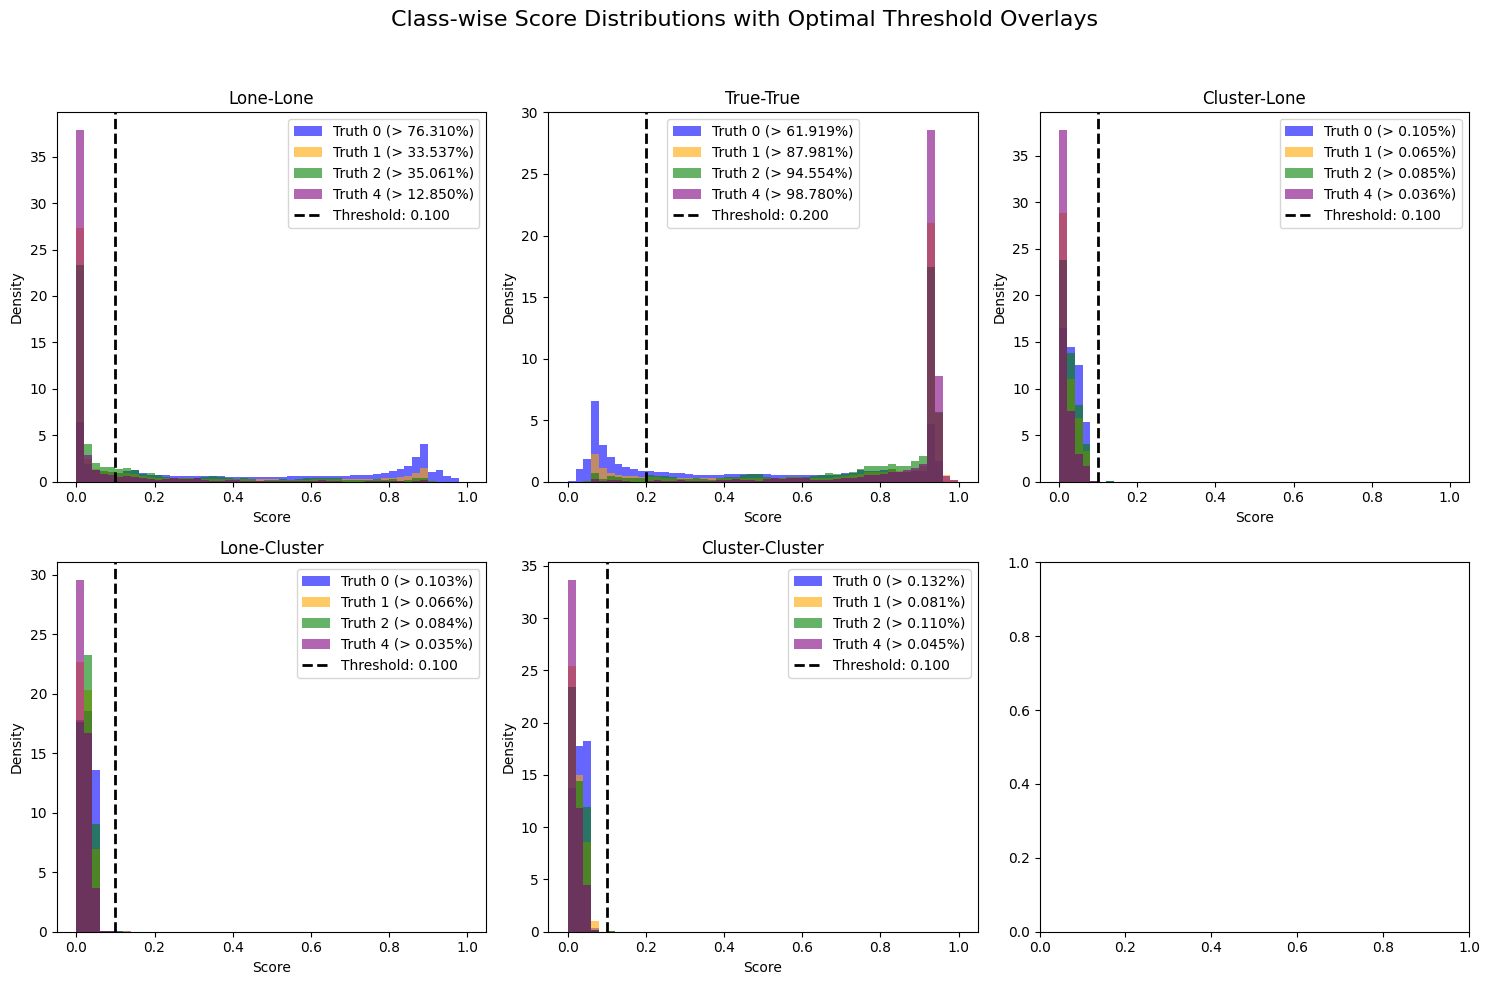

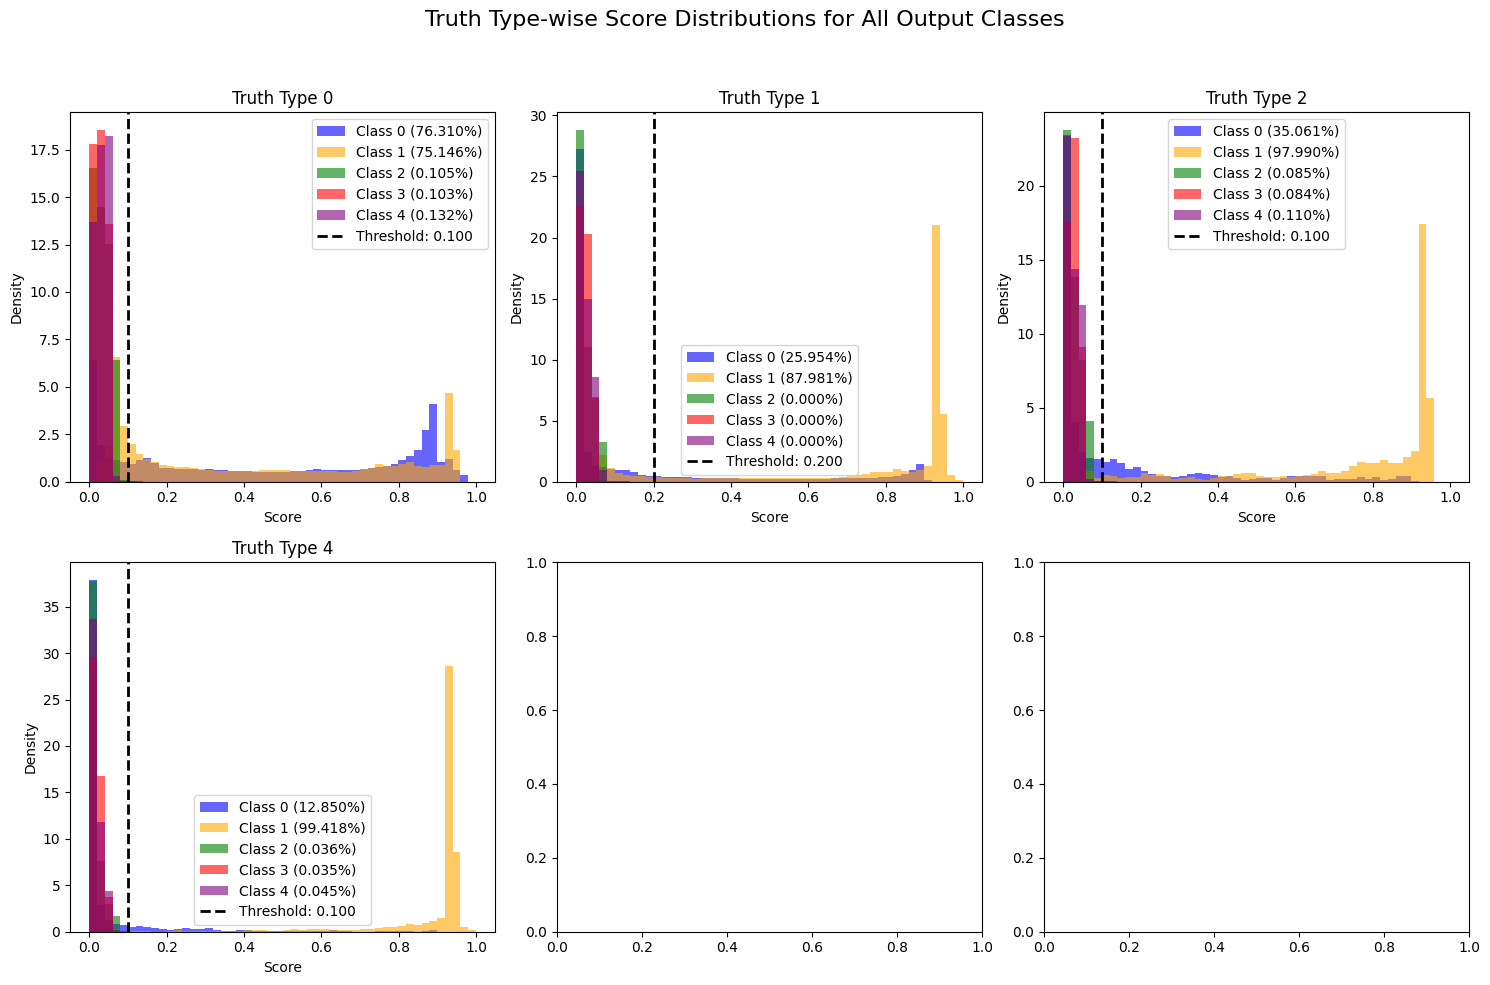

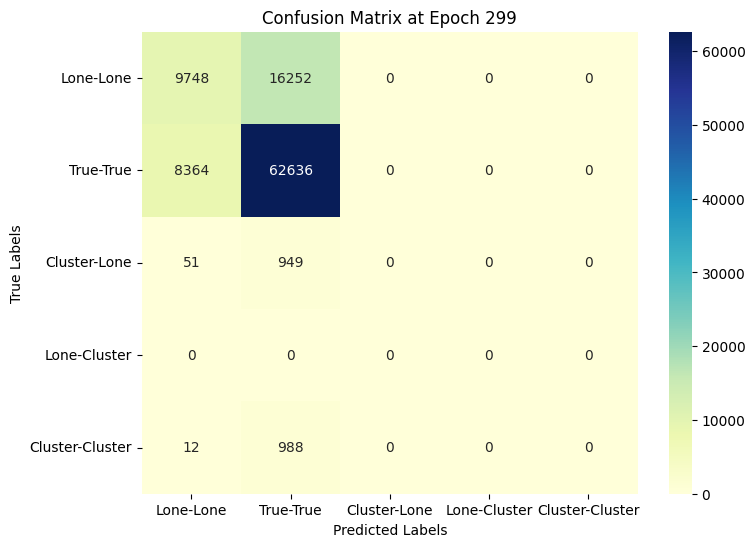

In [ ]:
plot_loss_curves(test_loss_per_epoch)
plot_roc_curves(test_scores_per_epoch, test_truth_labels)
plot_class_wise_distributions(test_scores_per_epoch, 
                              test_truth_labels, 
                              class_names, optimal_thresholds,
                              common_bins_test, 
                              colors)
plot_truth_type_distributions(test_scores_per_epoch, 
                              test_truth_labels, 
                              class_names, 
                              optimal_thresholds, 
                              common_bins_test, 
                              colors)
plot_confusion_matrix(test_scores_per_epoch, test_truth_labels, class_names, class_thresholds, 299)